# Binary Classification with Inception v3

In [3]:
# 1) Data generators setup (ImageDataGenerator)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
DATA_DIR = "/kaggle/input/animals10/raw-img"
IMG_SIZE = (227, 227)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    classes=['gatto', 'cane'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED,
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    classes=['gatto', 'cane'],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED,
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
print("Detected classes:", train_generator.class_indices)
print("Num classes:", len(train_generator.class_indices))

Found 5226 images belonging to 2 classes.
Found 1305 images belonging to 2 classes.
Detected classes: {'gatto': 0, 'cane': 1}
Num classes: 2


In [53]:
# 2) Inceptionv3 model definition (Keras)
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

def conv_bn_relu(x, filters, kernel_size, strides=1, padding='same', name=None):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False, name=name)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def inception_module(x, f1, f3r, f3, f5r, f5, pool_proj, name=None):
    b1 = conv_bn_relu(x, f1, (1,1))
    b2 = conv_bn_relu(x, f3r, (1,1))
    b2 = conv_bn_relu(b2, f3, (3,3))
    b3 = conv_bn_relu(x, f5r, (1,1))
    b3 = conv_bn_relu(b3, f5, (5,5))
    b4 = AveragePooling2D((3,3), strides=1, padding='same')(x)
    b4 = conv_bn_relu(b4, pool_proj, (1,1))
    return concatenate([b1, b2, b3, b4], axis=-1, name=name)

def build_inception_v3(input_shape=(227,227,3)):
    inputs = Input(shape=input_shape)

    # ===Stem===
    x = conv_bn_relu(inputs, 32, (3,3), strides=2, padding='valid')
    x = conv_bn_relu(x, 32, (3,3), padding='valid')
    x = conv_bn_relu(x, 64, (3,3))
    x = MaxPooling2D((3,3), strides=2)(x)

    # === Inception-blocks ===
    x = inception_module(x, 64, 48, 64, 8, 16, 16, name='inception_a1')
    x = inception_module(x, 64, 48, 64, 8, 16, 16, name='inception_a2')

    x = MaxPooling2D((3,3), strides=2)(x)
    x = inception_module(x, 128, 64, 96, 16, 32, 32, name='inception_b1')

    x = MaxPooling2D((3,3), strides=2)(x)
    x = inception_module(x, 192, 96, 128, 16, 32, 64, name='inception_c1')

    # === Classificator ===
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name='InceptionV3_Simplified_227x227')
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_inception_v3(input_shape=(227,227,3))
model.summary()

Model: "InceptionV3_Simplified_227x227"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_208 (Conv2D) │ (None, 113, 113,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 113, 113,  │        128 │ conv2d_208[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_211      │ (None, 113, 113,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_209 (Conv2D) │ (None, 111, 111,  │      9,216 │ activation_211[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        128 │ conv2d_209[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_212      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 111, 111,  │     18,432 │ activation_212[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        256 │ conv2d_210[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_213      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 55, 55,    │          0 │ activation_213[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 55, 55,    │      3,072 │ max_pooling2d_25… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 55, 55, 8) │        512 │ max_pooling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_212[0][0]  │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55, 8) │         32 │ conv2d_214[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_215      │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_217      │ (None, 55, 55, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 462,785 (1.77 MB)

 Trainable params: 459,873 (1.75 MB)

 Non-trainable params: 2,912 (11.38 KB)

In [5]:
# Utility: count model parameters and print size in MB
def count_params_and_size(model):
    params = model.count_params()
    size_bytes = params * 4
    size_mb = size_bytes / (1024**2)
    print(f'Total params: {params:,} ({size_mb:.2f} MB)')

count_params_and_size(model)

Total params: 462,785 (1.77 MB)


In [54]:
# 3) Train the model
EPOCHS = 3
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - accuracy: 0.6846 - loss: 0.6113 - val_accuracy: 0.2552 - val_loss: 0.8888
Epoch 2/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7551 - loss: 0.5139 - val_accuracy: 0.4261 - val_loss: 0.7687
Epoch 3/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.7858 - loss: 0.4661 - val_accuracy: 0.7287 - val_loss: 0.5011


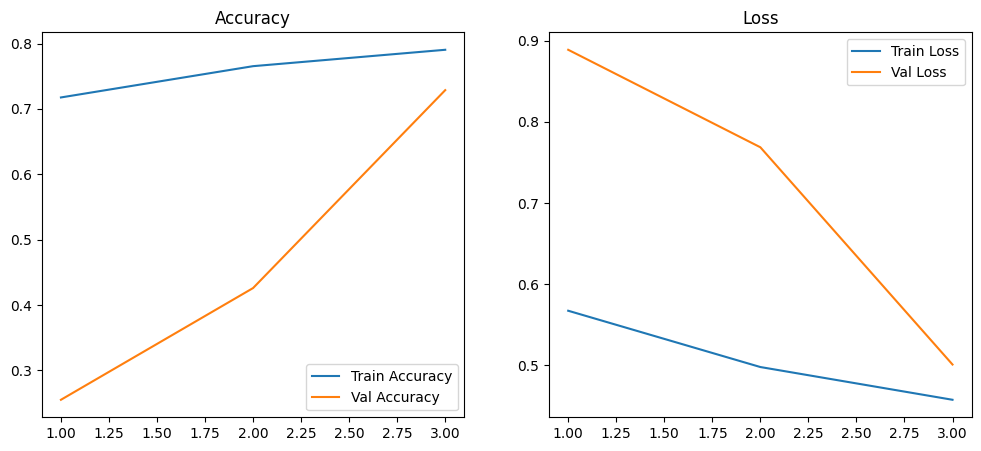

Validation samples: 1305 Batch size: 32 Steps: 41
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step


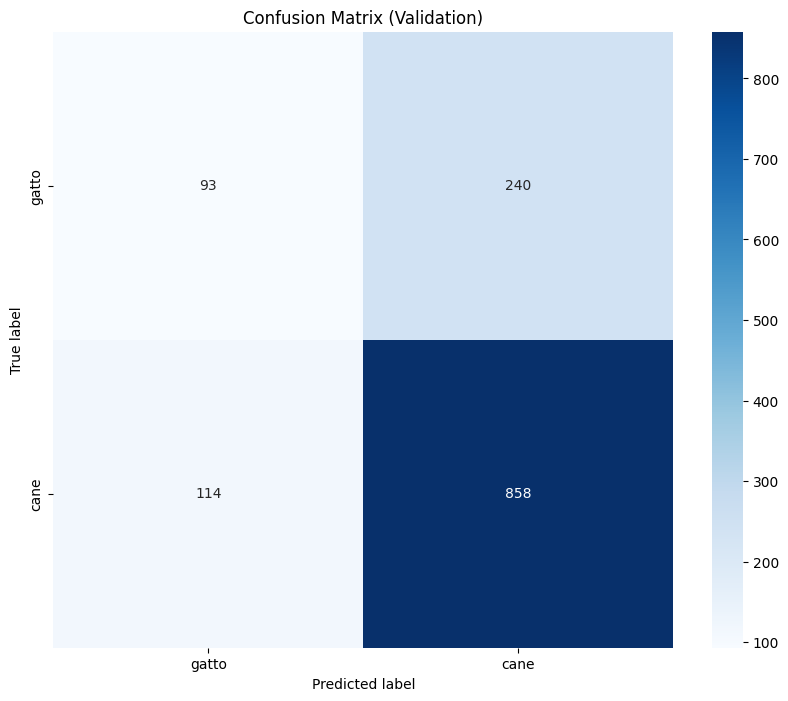

Classification report:
               precision    recall  f1-score   support

       gatto     0.4493    0.2793    0.3444       333
        cane     0.7814    0.8827    0.8290       972

    accuracy                         0.7287      1305
   macro avg     0.6153    0.5810    0.5867      1305
weighted avg     0.6967    0.7287    0.7053      1305

Accuracy: 0.7287  Precision: 0.6967  Recall: 0.7287  F1: 0.7053


In [55]:
# 4) Evaluation: plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import numpy as np

acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

val_steps = int(np.ceil(val_generator.samples / val_generator.batch_size))
print('Validation samples:', val_generator.samples, 'Batch size:', val_generator.batch_size, 'Steps:', val_steps)

y_pred_probs = model.predict(val_generator, steps=val_steps, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

y_true = val_generator.classes[:len(y_pred)]  # ensure same length

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
class_names = list(train_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (Validation)')
plt.show()

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print('Classification report:\n', report)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = np.mean(y_pred == y_true)
print(f'Accuracy: {accuracy:.4f}  Precision: {precision:.4f}  Recall: {recall:.4f}  F1: {f1:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


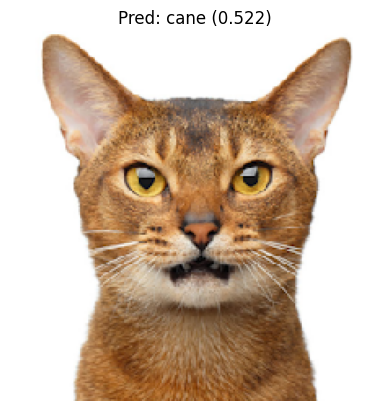

In [58]:
# 5) Predict a random image from dataset (visual check)
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

img = image.load_img('../input/images/Lab4/Cat2.png', target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
inp = np.expand_dims(img_array, axis=0)
probs = model.predict(inp)
pred_idx = (probs > 0.5).astype(int).flatten()[0]
pred_class = class_names[pred_idx]
conf = float(np.max(probs))
plt.imshow(img)
plt.axis('off')
plt.title(f'Pred: {pred_class} ({conf:.3f})')
plt.show()

In [59]:
# 6) Optimized InceptionV3 variant and comparison
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, SeparableConv2D, 
                                     BatchNormalization, Activation, MaxPooling2D, 
                                     AveragePooling2D, GlobalAveragePooling2D, 
                                     Dense, Dropout, concatenate)
from tensorflow.keras.optimizers import Adam

def conv_bn_relu(x, filters, kernel_size, strides=1, padding='same', separable=False):
    if separable:
        x = SeparableConv2D(
            filters, kernel_size, strides=strides, padding=padding, 
            use_bias=False,
            depthwise_initializer='he_normal',
            pointwise_initializer='he_normal'
        )(x)
    else:
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding, 
                   use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
    
def inception_module_light(x, f1, f3r, f3, pool_proj, name=None):
    b1 = conv_bn_relu(x, f1, (1,1))
    b2 = conv_bn_relu(x, f3r, (1,1))
    b2 = conv_bn_relu(b2, f3, (3,3), separable=True)
    b3 = AveragePooling2D((3,3), strides=1, padding='same')(x)
    b3 = conv_bn_relu(b3, pool_proj, (1,1))
    return concatenate([b1, b2, b3], axis=-1, name=name)
    
def build_inception_v3_optimized(input_shape=(227,227,3)):
    inp = Input(shape=input_shape)

    # Stem
    x = conv_bn_relu(inp, 16, (3,3), strides=2, padding='valid')
    x = conv_bn_relu(x, 32, (3,3))
    x = MaxPooling2D((3,3), strides=2)(x)

    # Inception-blocks
    x = inception_module_light(x, 32, 24, 32, 16, name='inception_a1')
    x = inception_module_light(x, 48, 32, 48, 16, name='inception_a2')
    x = MaxPooling2D((3,3), strides=2)(x)
    x = inception_module_light(x, 64, 48, 64, 24, name='inception_b1')

    # Classificator
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out, name='InceptionV3_Optimized')
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

orig_model = build_inception_v3(input_shape=(227,227,3))
small_model = build_inception_v3_optimized(input_shape=(227,227,3))  
def params_mb(m):
    p = m.count_params()
    return p, p*4/(1024**2)

orig_params, orig_mem = params_mb(orig_model)
small_params, small_mem = params_mb(small_model)

print(f'Original simplified InceptionV3 params: {orig_params:,} ({orig_mem:.2f} MB)')
print(f'Optimized InceptionV3 params          : {small_params:,} ({small_mem:.2f} MB)')
print(f'Reduction: {(1 - small_params/orig_params)*100:.2f}% fewer parameters')

Original simplified InceptionV3 params: 462,785 (1.77 MB)
Optimized InceptionV3 params          : 38,705 (0.15 MB)
Reduction: 91.64% fewer parameters


In [60]:
import time


SAMPLE_N = 64
NUM_IMAGES = 1024

all_images = []
for cls in os.listdir(DATA_DIR):
    cls_dir = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_dir):
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith(('.jpg','.jpeg','.png')):
                all_images.append((os.path.join(cls_dir, fn), cls))

# Random sample
if NUM_IMAGES > len(all_images):
    NUM_IMAGES = len(all_images)
sampled = random.sample(all_images, NUM_IMAGES)

sampled_paths = [p for p,_ in sampled[:SAMPLE_N]]
sample_imgs = []
for p in sampled_paths:
    img = image.load_img(p, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    sample_imgs.append(arr)
sample_array = np.array(sample_imgs)

_ = model.predict(sample_array[:8])
_ = small_model.predict(sample_array[:8])

t0 = time.time()
_ = model.predict(sample_array, batch_size=16)
t1 = time.time()
orig_time_per = (t1 - t0) / sample_array.shape[0]

t2 = time.time()
_ = small_model.predict(sample_array, batch_size=16)
t3 = time.time()
small_time_per = (t3 - t2) / sample_array.shape[0]

print(f'Original model time per image: {orig_time_per*1000:.2f} ms')
print(f'Small model time per image   : {small_time_per*1000:.2f} ms')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Original model time per image: 23.48 ms
Small model time per image   : 25.77 ms
